# 0. Setup & Environment

In [ ]:
%pip install "numpy>=2.0" "pandas>=2.1" pyhealth polars torch torchvision torchaudio transformers datasets scikit-learn matplotlib seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.8/113.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 30.0 MB/s eta 0:00:00


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == 'cuda':
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Total GPU Memory (GB):", round(torch.cuda.get_device_properties(0).total_memory / 1e9, 2))

Using device: cuda
GPU Name: Tesla T4
Total GPU Memory (GB): 15.83


In [ ]:
# @title Assertion
import numpy
import pandas
import pyhealth
import torch
import torchvision
import torchaudio
import transformers
import datasets
import sklearn
import matplotlib
import seaborn
import polars

print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("polars:", polars.__version__)
print("pyhealth:", pyhealth.__version__)
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("torchaudio:", torchaudio.__version__)
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", seaborn.__version__)

numpy: 2.0.2
pandas: 2.2.2
polars: 1.31.0
pyhealth: 1.1.3
torch: 2.9.0+cu126
torchvision: 0.24.0+cu126
torchaudio: 2.9.0+cu126
transformers: 4.57.2
datasets: 4.0.0
scikit-learn: 1.6.1
matplotlib: 3.10.0
seaborn: 0.13.2


# 1. Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/admissions.csv.gz" "/content/admissions.csv.gz"
!cp "/content/drive/MyDrive/patients.csv.gz" "/content/patients.csv.gz"
!cp "/content/drive/MyDrive/labevents.csv.gz" "/content/labevents.csv.gz"

!ls -lh /content/*.csv.gz

Mounted at /content/drive
-rw------- 1 root root  20M Nov 29 23:57 /content/admissions.csv.gz
-rw------- 1 root root 2.5G Nov 29 23:58 /content/labevents.csv.gz
-rw------- 1 root root 2.8M Nov 29 23:57 /content/patients.csv.gz


In [ ]:
import os, zipfile, numpy as np, pandas as pd
import torch
import torch.nn as nn
import polars as pl
from torch.utils.data import Dataset, DataLoader

cols_adm = ['subject_id', 'hadm_id', 'admittime']
cols_pat = ['subject_id', 'anchor_age', 'gender']
cols_lab = ['subject_id','hadm_id','itemid','charttime','valuenum','valueuom']

admissions = pl.read_csv("/content/admissions.csv.gz", columns=cols_adm)
patients = pl.read_csv("/content/patients.csv.gz", columns=cols_pat)
labevents = pl.read_csv("/content/labevents.csv.gz", columns=cols_lab, n_rows=10_000_000)

admissions = admissions.to_pandas()
patients = patients.to_pandas()
labevents = labevents.to_pandas()

print(admissions.shape)
print(patients.shape)
print(labevents.shape)

(546028, 3)
(364627, 3)
(10000000, 6)


In [ ]:
# @title Assertion
print("Labevents:", labevents.shape)
print("Admissions:", admissions.shape)
print("Patients:", patients.shape)

print(patients.columns.tolist())
print(admissions.columns.tolist())
print(labevents.columns.tolist())

Labevents: (10000000, 6)
Admissions: (546028, 3)
Patients: (364627, 3)
['subject_id', 'gender', 'anchor_age']
['subject_id', 'hadm_id', 'admittime']
['subject_id', 'hadm_id', 'itemid', 'charttime', 'valuenum', 'valueuom']


# 2. Preprocessing

In [ ]:
def preprocess_labevents(labevents, admissions, patients, max_events=10, top_n=50, use_weekday=True):
    """
    Preprocess lab events data for modeling.

    This function:
    1. Converts date columns to datetime objects.
    2. Computes patient age at admission.
    3. Selects top N most frequent lab items.
    4. Creates sequences of lab events for each patient admission,
       including optional demographic tokens (age and gender) at the start.
    5. Applies log transformation and clipping to lab values.

    Parameters:
    - labevents: DataFrame with lab events (columns: 'subject_id', 'hadm_id', 'itemid', 'charttime', 'valuenum', 'valueuom')
    - admissions: DataFrame with admissions info (columns: 'subject_id', 'hadm_id', 'admittime')
    - patients: DataFrame with patient info (columns: 'subject_id', 'anchor_age', 'gender')
    - max_events: Maximum number of lab events per admission to include
    - top_n: Number of most frequent lab items to keep
    - use_weekday: Whether to include weekday information in sequences

    Returns:
    - sequences: List of sequences per patient admission
    - top_labs: List of top N lab item IDs
    """
    import numpy as np
    import pandas as pd

    # Convert datetimes
    labevents['charttime'] = pd.to_datetime(labevents['charttime'])
    admissions['admittime'] = pd.to_datetime(admissions['admittime'])
    patients['anchor_age'] = pd.to_datetime(patients['anchor_age'])

    # Ensure matching types for merging
    labevents['hadm_id'] = labevents['hadm_id'].astype(str)
    admissions['hadm_id'] = admissions['hadm_id'].astype(str)
    labevents['subject_id'] = labevents['subject_id'].astype(str)
    admissions['subject_id'] = admissions['subject_id'].astype(str)
    patients['subject_id'] = patients['subject_id'].astype(str)

    # Compute patient age
    admissions = admissions.merge(
        patients[['subject_id','anchor_age','gender']],
        on='subject_id', how='left'
    )
    admissions['age'] = ((admissions['admittime'] - admissions['anchor_age']).dt.days // 365).clip(0,120)

    # Select top N labs
    top_labs = labevents['itemid'].value_counts().head(top_n).index.tolist()
    df = labevents[labevents['itemid'].isin(top_labs)]
    df = df.merge(
        admissions[['subject_id','hadm_id','admittime','age','gender']],
        on=['subject_id','hadm_id'], how='left'
    )

    sequences = []
    for _, group in df.groupby(['subject_id','hadm_id']):
        group = group.sort_values('charttime')
        seq = []

        # Demographics tokens at start
        age_token = f"AGE{group['age'].iloc[0]//10}"
        gender_val = str(group['gender'].iloc[0]) if pd.notnull(group['gender'].iloc[0]) else "U"
        gender_token = f"G{gender_val[0].upper()}"
        seq.append({"lab": age_token, "value":"0", "unit":"unit0", "day":0, "weekday":0, "hour":0, "minute":0})
        seq.append({"lab": gender_token, "value":"0", "unit":"unit0", "day":0, "weekday":0, "hour":0, "minute":0})

        for _, row in group.head(max_events).iterrows():
            try:
                val = float(row['valuenum'])
                if val <= 0 or np.isnan(val):
                    continue
                val = np.log1p(val)
                val = np.clip(val, 0.01, 10.0)
            except:
                continue
            if pd.isnull(row['admittime']) or pd.isnull(row['charttime']):
                continue
            delta = row['charttime'] - row['admittime']
            seq.append({
                "lab": str(row['itemid']),
                "value": f"{val:.2f}",
                "unit": f"unit{str(row['valueuom'])[:1]}",
                "day": delta.days % 31,
                "weekday": row['charttime'].weekday() if use_weekday else 0,
                "hour": row['charttime'].hour,
                "minute": row['charttime'].minute
            })
        if len(seq) > 0:
            sequences.append(seq)

    return sequences, top_labs


sequences, top_labs = preprocess_labevents(labevents, admissions, patients, max_events=10, top_n=50, use_weekday=True)

In [ ]:
# @title Assertion
# Check total number of sequences
print(f"Total sequences generated: {len(sequences)}")
assert len(sequences) > 0, "No sequences generated!"

# Check sequence length distribution
seq_lengths = [len(seq) for seq in sequences]
print(f"Min seq length: {min(seq_lengths)}, Max seq length: {max(seq_lengths)}, Mean seq length: {np.mean(seq_lengths):.2f}")

# Inspect first sequence (demographics + first lab events)
import pprint
print("First sequence sample:")
pprint.pprint(sequences[0])

# Verify top labs
print(f"Top labs ({len(top_labs)}): {top_labs}")
assert len(top_labs) == 50, "Top N labs count mismatch!"

# Check value ranges
values = [float(e['value']) for seq in sequences for e in seq if e['lab'].startswith("AGE")==False and e['lab'].startswith("G")==False]
print(f"Lab value range after log+clip: min={min(values):.2f}, max={max(values):.2f}")
assert all(0.01 <= v <= 10.0 for v in values), "Some values are out of expected range!"

# Sanity check demographics tokens
dem_tokens = [e['lab'] for seq in sequences for e in seq[:2]]  # first two should be AGE/GENDER
print(f"Sample demographics tokens: {dem_tokens[:10]}")
assert all(t.startswith("AGE") or t.startswith("G") for t in dem_tokens[:10]), "Demographics tokens missing or malformed"

Total sequences generated: 47006
Min seq length: 2, Max seq length: 12, Mean seq length: 7.24
First sequence sample:
[{'day': 0,
  'hour': 0,
  'lab': 'AGE12.0',
  'minute': 0,
  'unit': 'unit0',
  'value': '0',
  'weekday': 0},
 {'day': 0,
  'hour': 0,
  'lab': 'GF',
  'minute': 0,
  'unit': 'unit0',
  'value': '0',
  'weekday': 0},
 {'day': 0,
  'hour': 0,
  'lab': '51491',
  'minute': 10,
  'unit': 'unitu',
  'value': '1.95',
  'weekday': 6},
 {'day': 0,
  'hour': 0,
  'lab': '51492',
  'minute': 10,
  'unit': 'unitm',
  'value': '3.43',
  'weekday': 6}]
Top labs (50): [50912, 51221, 51006, 51265, 51222, 50971, 51301, 51249, 51248, 51250, 51279, 51277, 50983, 50902, 50882, 50868, 50931, 50893, 50960, 50970, 50934, 51678, 50947, 52172, 50861, 51237, 51274, 50878, 50920, 51275, 51244, 51256, 51254, 51200, 51146, 50863, 50885, 50862, 52075, 52033, 51464, 51508, 51506, 51466, 51478, 51484, 51486, 51487, 51491, 51492]
Lab value range after log+clip: min=0.08, max=9.63
Sample demographics

# 3. Tokenization

In [ ]:
class LabTOPTokenizer:
    """
    Tokenizer for LabTOP sequences, including demographics and lab events.

    This class converts lab events and associated features (value, unit, time) into
    integer token sequences for model input. Special tokens and discrete
    representations are used for lab values, time, and demographics.
    """

    def __init__(self, top_labs, add_demographics=True):
        """
        Initialize tokenizer with:
        - top_labs: list of lab item IDs to include in the vocabulary
        - add_demographics: whether to include age/gender tokens
        """
        self.special = {"PAD":0, "EOE":1}  # PAD = padding, EOE = end of event
        base = 2  # start indexing after special tokens

        # Demographics tokens
        self.demographics_tokens = {}
        if add_demographics:
            # Age tokens: AGE0, AGE1, ..., AGE12 (decades 0-120)
            for i in range(13):
                self.demographics_tokens[f"AGE{i}"] = base + i
            base += 13

            # Gender tokens: GM (male), GF (female)
            for g in ['GM','GF']:
                self.demographics_tokens[g] = base
                base += 1

        # Lab tokens
        self.lab2idx = {str(lab): base+i for i, lab in enumerate(top_labs)}
        base += len(top_labs)

        # Value digits and decimal point
        self.digit2idx = {str(i): base+i for i in range(10)}  # digits 0-9
        base += 10
        self.digit2idx["."] = base  # decimal point
        base += 1

        # Unit tokens (unit0-unit9)
        self.unit2idx = {f"unit{i}": base+i for i in range(10)}
        base += 10

        # Day tokens (DAY0-DAY30)
        self.day2idx = {f"DAY{i}": base+i for i in range(31)}
        base += 31

        # Weekday tokens (W0-W6)
        self.week2idx = {f"W{i}": base+i for i in range(7)}
        base += 7

        # Hour tokens (H0-H23)
        self.hour2idx = {f"H{i}": base+i for i in range(24)}
        base += 24

        # Minute tokens (10-min intervals, M0-M5)
        self.min2idx = {f"M{i}": base+i for i in range(6)}
        base += 6

        # Total vocabulary size
        self.vocab_size = base

    def encode_event(self, lab, value, unit, day, weekday, hour, minute):
        """
        Convert a lab event into a sequence of integer tokens.

        Parameters:
        - lab: lab ID or demographic token (str)
        - value: numeric value as string (e.g., '2.34')
        - unit: unit token (e.g., 'unit0')
        - day: day offset from admission (0-30)
        - weekday: day of the week (0=Monday)
        - hour: hour of day (0-23)
        - minute: minute of day (0-59), encoded as 10-min interval

        Returns:
        - seq: list of integer tokens representing this event
        """

        # Lab token/demographic token
        seq = [self.lab2idx.get(lab, self.demographics_tokens.get(lab, 0))]

        # Value tokens (digit by digit)
        for ch in value:
            seq.append(self.digit2idx.get(ch,0))

        # Unit token
        seq.append(self.unit2idx.get(unit,0))

        # Time tokens: day, weekday, hour, minute
        seq.append(self.day2idx.get(f"DAY{day}",0))
        seq.append(self.week2idx.get(f"W{weekday}",0))
        seq.append(self.hour2idx.get(f"H{hour}",0))
        seq.append(self.min2idx.get(f"M{minute//10}",0))

        # End-of-event token
        seq.append(self.special["EOE"])

        return seq

tokenizer = LabTOPTokenizer(top_labs)

In [ ]:
# @title Assertion
# Check vocabulary sizes
print("Vocabulary size:", tokenizer.vocab_size)
assert tokenizer.vocab_size > 0, "Tokenizer vocab_size should be > 0"

# Check demographics tokens
print("Demographics tokens:", tokenizer.demographics_tokens)
assert "AGE0" in tokenizer.demographics_tokens, "AGE0 token missing"
assert "GM" in tokenizer.demographics_tokens, "Gender token GM missing"

# Check lab tokens
print("Sample lab tokens:", list(tokenizer.lab2idx.items())[:5])
assert len(tokenizer.lab2idx) == len(top_labs), "Lab token count mismatch"

# Encode a dummy event
sample_event = {
    "lab": str(top_labs[0]),  # use first top lab
    "value": "2.34",
    "unit": "unit0",
    "day": 1,
    "weekday": 2,
    "hour": 14,
    "minute": 23
}

encoded = tokenizer.encode_event(**sample_event)
print("Encoded event:", encoded)
assert isinstance(encoded, list), "Encoded output should be a list"
assert all(isinstance(tok, int) for tok in encoded), "All tokens must be integers"
assert encoded[-1] == tokenizer.special["EOE"], "Last token must be EOE"

# Encode a demographics token
dem_event = {"lab": "AGE3", "value":"0", "unit":"unit0", "day":0, "weekday":0, "hour":0, "minute":0}
encoded_dem = tokenizer.encode_event(**dem_event)
print("Encoded demographics:", encoded_dem)
assert encoded_dem[0] == tokenizer.demographics_tokens["AGE3"], "Demographics token mismatch"

Vocabulary size: 156
Demographics tokens: {'AGE0': 2, 'AGE1': 3, 'AGE2': 4, 'AGE3': 5, 'AGE4': 6, 'AGE5': 7, 'AGE6': 8, 'AGE7': 9, 'AGE8': 10, 'AGE9': 11, 'AGE10': 12, 'AGE11': 13, 'AGE12': 14, 'GM': 15, 'GF': 16}
Sample lab tokens: [('50912', 17), ('51221', 18), ('51006', 19), ('51265', 20), ('51222', 21)]
Encoded event: [17, 69, 77, 70, 71, 78, 89, 121, 140, 152, 1]
Encoded demographics: [5, 67, 78, 88, 119, 126, 150, 1]


# 4. Padding and Batching

In [ ]:
class LabTOPDataset(Dataset):
    """
    Dataset for LabTOP sequences.

    Converts preprocessed sequences of lab events (and demographics) into
    fixed-length input and target tensors suitable for sequence modeling.

    Each sample is:
        - inp: token IDs sequence shifted left by 1 (model input)
        - tgt: token IDs sequence shifted right by 1 (model target)
    """

    def __init__(self, sequences, tokenizer, max_len=128):
        """
        Initialize the dataset.

        Parameters:
        - sequences: list of sequences from preprocess_labevents()
                     (each sequence is a list of dicts with keys: lab, value, unit, day, weekday, hour, minute)
        - tokenizer: LabTOPTokenizer object for converting events to token IDs
        - max_len: maximum sequence length for padding/truncation
        """
        self.samples = []
        self.max_len = max_len

        for seq in sequences:
            flat_seq = []
            for e in seq:
                flat_seq.extend(tokenizer.encode_event(**e))
            if len(flat_seq) < 2:
                continue
            inp = flat_seq[:-1]
            tgt = flat_seq[1:]

            # Fixed-length padding / truncation
            inp = (inp + [0]*self.max_len)[:self.max_len]
            tgt = (tgt + [0]*self.max_len)[:self.max_len]

            # Convert to tensors and store as a sample
            self.samples.append((torch.tensor(inp), torch.tensor(tgt)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

split_idx = int(0.8 * len(sequences)) # 4:1 = training:validation
train_ds = LabTOPDataset(sequences[:split_idx], tokenizer)
val_ds = LabTOPDataset(sequences[split_idx:], tokenizer)

In [ ]:
# @title Assertion
# dataset lengths
print(f"Total sequences: {len(sequences)}")
print(f"Training samples: {len(train_ds)}, Validation samples: {len(val_ds)}")

assert len(train_ds) > 0, "Training dataset is empty!"
assert len(val_ds) > 0, "Validation dataset is empty!"

# sample structure
sample_inp, sample_tgt = train_ds[0]
print("Input shape:", sample_inp.shape)
print("Target shape:", sample_tgt.shape)
print("Sample input tokens:", sample_inp[:10])
print("Sample target tokens:", sample_tgt[:10])

assert isinstance(sample_inp, torch.Tensor), "Input should be a torch.Tensor"
assert isinstance(sample_tgt, torch.Tensor), "Target should be a torch.Tensor"
assert sample_inp.shape == sample_tgt.shape, "Input and target must have the same shape"

# padding
assert sample_inp[-1] == 0 or sample_tgt[-1] == 0, "Last token should be PAD (0) if sequence < max_len"

# max length
assert sample_inp.shape[0] == train_ds.max_len, "Sequence length must equal max_len"

Total sequences: 47006
Training samples: 37604, Validation samples: 9402
Input shape: torch.Size([128])
Target shape: torch.Size([128])
Sample input tokens: tensor([  0,  67,  78,  88, 119, 126, 150,   1,  16,  67])
Sample target tokens: tensor([ 67,  78,  88, 119, 126, 150,   1,  16,  67,  78])


# 5. Dataloader

In [ ]:
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

In [ ]:
# @title Assertion
# number of batches
print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

assert len(train_loader) > 0, "Training DataLoader is empty!"
assert len(val_loader) > 0, "Validation DataLoader is empty!"

# batch shapes
x_batch, y_batch = next(iter(train_loader))
print("Input batch shape:", x_batch.shape)
print("Target batch shape:", y_batch.shape)

assert x_batch.shape[0] == 16, "Batch size should be 16 (except possibly last batch)"
assert x_batch.shape == y_batch.shape, "Input and target batch shapes must match"

# data types
assert x_batch.dtype == torch.long, "Input batch should be of type torch.long"
assert y_batch.dtype == torch.long, "Target batch should be of type torch.long"

# padding tokens
PAD_token = 0
print("Number of PAD tokens in batch:", (x_batch == PAD_token).sum().item())

Training batches: 2351, Validation batches: 588
Input batch shape: torch.Size([16, 128])
Target batch shape: torch.Size([16, 128])
Number of PAD tokens in batch: 1303


# 6. Embedding & Transformer

In [ ]:
import torch
import torch.nn as nn

class LabTOPTransformer(nn.Module):
    def __init__(self, vocab, d_model=128, nhead=4, nlayers=2, max_len=512, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab, d_model, padding_idx=0)
        self.pos = nn.Embedding(max_len, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=d_model*4,
                                                   batch_first=True, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.fc = nn.Linear(d_model, vocab)
        self.max_len = max_len

    def _generate_mask(self, L, device):
        # mask shape expected by TransformerEncoder is (L, L)
        # True positions will be masked (i.e., -inf). We produce a float mask for src_mask.
        mask = torch.triu(torch.full((L, L), float('-inf'), device=device), diagonal=1)
        return mask  # shape (L,L), float -inf where masked, 0 elsewhere

    def forward(self, x):
        # x: [B, L] token ids
        B, L = x.shape
        if L > self.max_len:
            raise ValueError("Sequence length > max_len")
        pos_idx = torch.arange(L, device=x.device).unsqueeze(0)  # [1, L]
        x_emb = self.embedding(x) + self.pos(pos_idx)            # [B, L, d_model]

        # Create causal mask for encoder: pass as src_mask
        src_mask = self._generate_mask(L, x.device)      # (L, L)
        # TransformerEncoder supports src_key_padding_mask for padded tokens; we'll pass later in training if desired.

        out = self.encoder(x_emb, mask=src_mask)                # [B, L, d_model]
        logits = self.fc(out)                                   # [B, L, vocab]
        return logits

model = LabTOPTransformer(vocab=tokenizer.vocab_size, d_model=128, nhead=4, nlayers=2)

In [ ]:
# @title Assertion
model = LabTOPTransformer(vocab=tokenizer.vocab_size, d_model=128, nhead=4, nlayers=2)
assert isinstance(model, nn.Module), "Model must be an instance of nn.Module"
dummy_input = torch.randint(0, tokenizer.vocab_size, (2, 16))
logits = model(dummy_input)

assert logits.shape == (2, 16, tokenizer.vocab_size), f"Expected shape (2,16,{tokenizer.vocab_size}), got {logits.shape}"
assert not torch.isnan(logits).any(), "Logits contain NaNs"
print("LabTOPTransformer forward pass assertion passed")

LabTOPTransformer forward pass assertion passed


# 7. Model Input & Training

In [ ]:
# @title Assertion (sanity checks, before training)
# model type
assert isinstance(model, nn.Module), "Model must be an nn.Module instance"

# loaders
assert len(train_loader) > 0, "Training loader is empty"
if val_loader:
    assert len(val_loader) > 0, "Validation loader is empty"

# a single batch from training loader
x_sample, y_sample = next(iter(train_loader))
assert x_sample.shape[0] == y_sample.shape[0], "Batch size mismatch between x and y"
assert x_sample.ndim == 2 and y_sample.ndim == 2, "Input/target must be 2D tensors [batch, seq_len]"

# values in input batch are within vocab range
assert x_sample.max() < tokenizer.vocab_size and x_sample.min() >= 0, "Input token IDs out of range"
assert y_sample.max() < tokenizer.vocab_size and y_sample.min() >= 0, "Target token IDs out of range"

# run a single forward + backward pass to verify everything works
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
x_sample, y_sample = x_sample.to(device), y_sample.to(device)
logits = model(x_sample)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
loss = loss_fn(logits.view(-1, logits.size(-1)), y_sample.view(-1))
loss.backward()
print("Single forward/backward pass assertion passed. Training loop can run.")

Single forward/backward pass assertion passed. Training loop can run.


In [ ]:
# Use it for assertion and plot graph
train_losses = []
val_losses = []

def train(model, loader, val_loader=None, epochs=10):
    """
    Train a LabTOP Transformer model on lab event sequences.

    Steps:
    1. Move model to GPU if available.
    2. Initialize optimizer (Adam) and loss function (CrossEntropyLoss with PAD ignored).
    3. Loop over epochs:
        a. Training phase:
            - Set model to train mode.
            - For each batch from the training loader:
                i. Move input (x) and target (y) to device.
                ii. Forward pass through the model to get logits.
                iii. Compute loss between predicted logits and target tokens.
                iv. Backpropagate gradients and update model parameters.
            - Compute average training loss for the epoch.
        b. Validation phase:
            - Set model to evaluation mode.
            - Disable gradient computation.
            - Compute forward pass and loss on validation batches.
            - Compute average validation loss for the epoch.
    4. Print training and validation loss per epoch.

    Parameters:
    - model: LabTOPTransformer instance
    - loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - epochs: number of training epochs
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)
    for ep in range(epochs):
        model.train()
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits.view(-1, model.fc.out_features), y.view(-1))
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)

        val_loss = 0
        if val_loader:
            model.eval()
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    logits_val = model(x_val)
                    loss_val = loss_fn(logits_val.view(-1, model.fc.out_features), y_val.view(-1))
                    val_loss += loss_val.item()
            val_loss /= len(val_loader)
        train_losses.append(avg_loss)
        val_losses.append(val_loss)

        print(f"Epoch {ep+1}/{epochs}, Train Loss={avg_loss:.4f}, Validation Loss={val_loss:.4f}")

train(model, train_loader, val_loader, epochs=10)

Using device: cuda
Epoch 1/10, Train Loss=0.5925, Validation Loss=0.4622
Epoch 2/10, Train Loss=0.4644, Validation Loss=0.4467
Epoch 3/10, Train Loss=0.4499, Validation Loss=0.4369
Epoch 4/10, Train Loss=0.4422, Validation Loss=0.4328
Epoch 5/10, Train Loss=0.4376, Validation Loss=0.4260
Epoch 6/10, Train Loss=0.4340, Validation Loss=0.4252
Epoch 7/10, Train Loss=0.4319, Validation Loss=0.4239
Epoch 8/10, Train Loss=0.4297, Validation Loss=0.4223
Epoch 9/10, Train Loss=0.4283, Validation Loss=0.4196
Epoch 10/10, Train Loss=0.4267, Validation Loss=0.4191


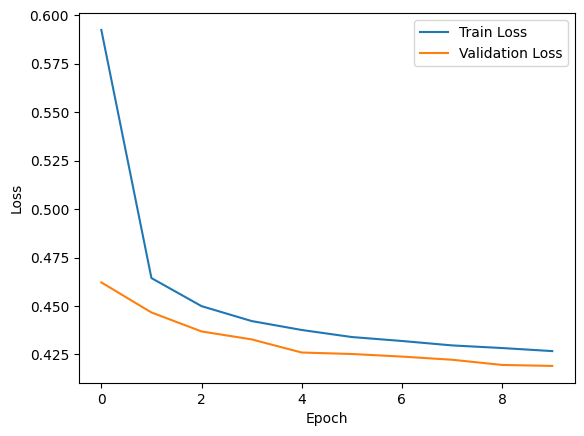

All assertions passed: Loss curves look reasonable.


In [ ]:
# @title Assertion
assert isinstance(train_losses, list), "train_losses should be a list"
assert isinstance(val_losses, list), "val_losses should be a list"
assert len(train_losses) == len(val_losses), "Train and val losses should have same length"

# losses are positive numbers
assert all(l > 0 for l in train_losses), "All train losses should be positive"
assert all(l > 0 for l in val_losses), "All val losses should be positive"

# losses decrease at least once
assert train_losses[-1] <= train_losses[0], "Train loss did not decrease"
assert val_losses[-1] <= val_losses[0], "Validation loss did not decrease"

# Plot graph
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("All assertions passed: Loss curves look reasonable.")

# 8. Evaluation

Per-token accuracy (ignoring PAD): 0.8371


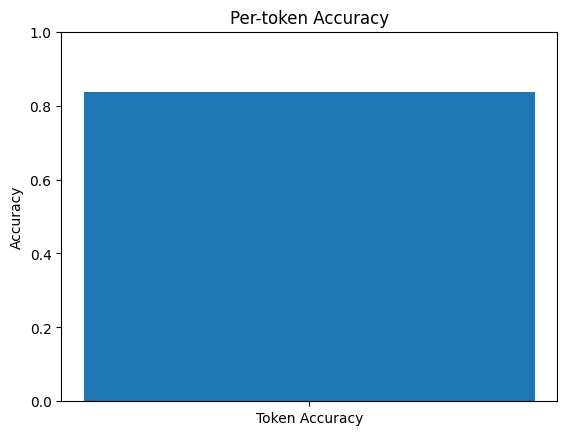

Lab 50912 (itemid) -> MAE=0.132, NMAE=0.217
Lab 51221 (itemid) -> MAE=0.128, NMAE=0.231
Lab 51006 (itemid) -> MAE=0.261, NMAE=0.531
Lab 51265 (itemid) -> MAE=0.225, NMAE=0.472
Lab 51222 (itemid) -> MAE=0.087, NMAE=0.175
Lab 50971 (itemid) -> MAE=0.110, NMAE=0.176
Lab 51301 (itemid) -> MAE=0.232, NMAE=0.487
Lab 51249 (itemid) -> MAE=0.054, NMAE=0.104
Lab 51248 (itemid) -> MAE=0.071, NMAE=0.173
Lab 51250 (itemid) -> MAE=0.075, NMAE=0.150
Lab 51279 (itemid) -> MAE=0.130, NMAE=0.231
Lab 51277 (itemid) -> MAE=0.102, NMAE=0.146
Lab 50983 (itemid) -> MAE=0.027, NMAE=0.029
Lab 50902 (itemid) -> MAE=0.048, NMAE=0.076
Lab 50882 (itemid) -> MAE=0.120, NMAE=0.404
Lab 50868 (itemid) -> MAE=0.163, NMAE=0.275
Lab 50931 (itemid) -> MAE=0.199, NMAE=0.353
Lab 50893 (itemid) -> MAE=0.085, NMAE=0.299
Lab 50960 (itemid) -> MAE=0.061, NMAE=0.204
Lab 50970 (itemid) -> MAE=0.149, NMAE=0.302
Lab 50934 (itemid) -> MAE=0.258, NMAE=0.539
Lab 51678 (itemid) -> MAE=0.274, NMAE=0.558
Lab 50947 (itemid) -> MAE=0.023,

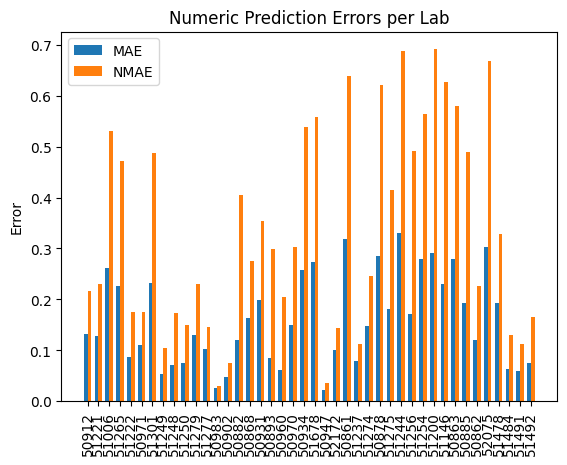

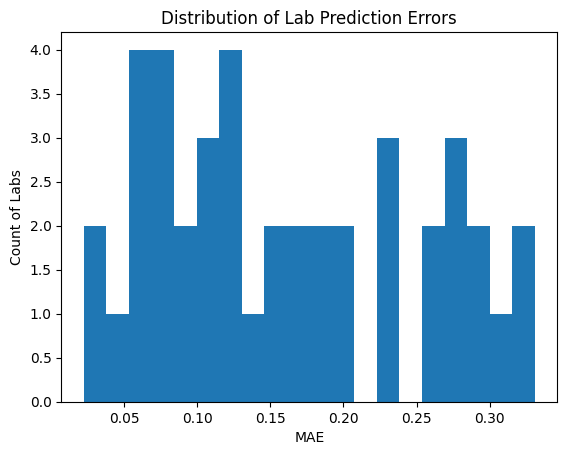


===== Sample Predictions (first 5 sequences) =====
Sequence 1:
Input tokens  : [0, 67, 78, 88, 119, 126, 150, 1, 0, 67, 78, 88, 119, 126, 150, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True tokens   : [67, 78, 88, 119, 126, 150, 1, 0, 67, 78, 88, 119, 126, 150, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predicted tokens: [67, 78, 88, 119, 126, 150, 1, 16, 67, 78, 88, 119, 126, 150, 1, 18, 69, 77, 67,

In [ ]:
@torch.no_grad()
def evaluate(model, loader, tokenizer=None, top_labs=None, n_examples=5):
    """
    Comprehensive evaluation of LabTOP model.

    Includes:
    1. Token-level accuracy
    2. Per-lab numeric metrics (MAE, NMAE)
    3. Training/validation loss visualization (if available)
    4. Qualitative inspection of predictions
    5. Plots: token accuracy, numeric errors, error distribution

    Parameters:
    - model: LabTOPTransformer instance
    - loader: DataLoader for evaluation
    - tokenizer: LabTOPTokenizer instance (required for numeric metrics)
    - top_labs: list of top lab IDs (required for numeric metrics)
    - n_examples: number of sequences to inspect qualitatively

    Returns:
    - token_acc: float
    - lab_metrics: dict of numeric metrics per lab
    """
    model.eval()
    device = next(model.parameters()).device

    # Token-level accuracy
    total_tokens, correct_tokens = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=-1)
        mask = y != 0
        correct_tokens += (preds == y).masked_select(mask).sum().item()
        total_tokens += mask.sum().item()
    token_acc = correct_tokens / total_tokens
    print(f"Per-token accuracy (ignoring PAD): {token_acc:.4f}")

    plt.bar(["Token Accuracy"], [token_acc])
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.title("Per-token Accuracy")
    plt.show()

    # Numeric metrics per lab
    lab_metrics = None
    if tokenizer and top_labs:
        lab_metrics = {}
        def decode_value(pred_tokens):
            digits_map = {v:k for k,v in tokenizer.digit2idx.items()}
            val_str = "".join([digits_map[t] for t in pred_tokens if t in digits_map])
            try:
                return float(val_str)
            except:
                return np.nan

        for lab in top_labs:
            lab_token = tokenizer.lab2idx.get(str(lab))
            preds_list, trues_list = [], []
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                pred_tokens_batch = torch.argmax(logits, dim=-1)
                for i in range(x.shape[0]):
                    seq = x[i].cpu().tolist()
                    y_seq = y[i].cpu().tolist()
                    pred_seq = pred_tokens_batch[i].cpu().tolist()
                    idxs = [j for j,tok in enumerate(seq) if tok==lab_token]
                    for idx in idxs:
                        val_pred_tokens, val_true_tokens = [], []
                        j = idx + 1
                        while j < len(seq):
                            if seq[j]==0 or seq[j]==tokenizer.special["EOE"]:
                                break
                            if seq[j] in tokenizer.digit2idx.values() or seq[j]==tokenizer.digit2idx["."]:
                                val_pred_tokens.append(pred_seq[j])
                                val_true_tokens.append(y_seq[j])
                            j+=1
                        pred_val = decode_value(val_pred_tokens)
                        true_val = decode_value(val_true_tokens)
                        if not np.isnan(pred_val) and not np.isnan(true_val):
                            preds_list.append(pred_val)
                            trues_list.append(true_val)
            if len(preds_list) > 0:
                preds_arr = np.array(preds_list)
                trues_arr = np.array(trues_list)
                mae = np.mean(np.abs(preds_arr - trues_arr))
                nmae = mae / (np.mean(trues_arr)+1e-8)
                lab_metrics[lab] = {"MAE": mae, "NMAE": nmae}
            else:
                lab_metrics[lab] = None

        labs, mae_vals, nmae_vals = [], [], []
        for lab, metrics in lab_metrics.items():
            if metrics is not None:
                print(f"Lab {lab} (itemid) -> MAE={metrics['MAE']:.3f}, NMAE={metrics['NMAE']:.3f}")
                labs.append(str(lab))
                mae_vals.append(metrics["MAE"])
                nmae_vals.append(metrics["NMAE"])
        if labs:
            x = np.arange(len(labs))
            width = 0.35
            plt.bar(x - width/2, mae_vals, width, label='MAE')
            plt.bar(x + width/2, nmae_vals, width, label='NMAE')
            plt.xticks(x, labs, rotation=90)
            plt.ylabel("Error")
            plt.title("Numeric Prediction Errors per Lab")
            plt.legend()
            plt.show()

            plt.hist(mae_vals, bins=20)
            plt.xlabel("MAE")
            plt.ylabel("Count of Labs")
            plt.title("Distribution of Lab Prediction Errors")
            plt.show()

    # Qualitative inspection
    print(f"\n===== Sample Predictions (first {n_examples} sequences) =====")
    cnt = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=-1)
        for i in range(x.shape[0]):
            if cnt >= n_examples:
                break
            seq_tokens = x[i].cpu().tolist()
            true_tokens = y[i].cpu().tolist()
            pred_tokens = preds[i].cpu().tolist()
            print(f"Sequence {cnt+1}:")
            print("Input tokens  :", seq_tokens)
            print("True tokens   :", true_tokens)
            print("Predicted tokens:", pred_tokens)
            print("-"*40)
            cnt += 1
        if cnt >= n_examples:
            break

    return token_acc, lab_metrics

token_acc, lab_metrics = evaluate(model, val_loader, tokenizer, top_labs, n_examples=5)

# 9. Export Model

In [ ]:
from google.colab import drive
import torch
from datetime import datetime

drive.mount('/content/drive')
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = f"/content/drive/MyDrive/labtop_model_{timestamp}.pth"

torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/MyDrive/labtop_model_20251130_000653.pth


In [ ]:
# @title Assertion
import os

assert os.path.exists(save_path), f"Model file not found at {save_path}"
assert os.path.getsize(save_path) > 0, f"Saved file is empty: {save_path}"

# 10. Inference

In [ ]:
import torch
import torch.nn as nn

tokenizer = LabTOPTokenizer(top_labs)
model = LabTOPTransformer(tokenizer.vocab_size)
state_dict = torch.load(save_path, map_location='cpu')
model.load_state_dict(state_dict)
model.eval()

test_input = torch.tensor([[0, 2, 5, 10]], dtype=torch.long)

with torch.no_grad():
    logits = model(test_input)

In [ ]:
# @title Assertion
import torch

assert logits.shape[0] == test_input.shape[0], "Batch size mismatch"
assert logits.shape[1] == test_input.shape[1], "Sequence length mismatch"
assert logits.shape[2] == tokenizer.vocab_size, "Vocab size mismatch"

print("Logits shape is correct:", logits.shape)

Logits shape is correct: torch.Size([1, 4, 156])


# 11. Prediction

In [ ]:
import torch
from copy import deepcopy

def predict_event(model, tokenizer, input_seq, max_pred=3, device=None, verbose=False):
    if device is None:
        device = next(model.parameters()).device
    model.eval()

    # Encode input sequence
    tokens = []
    for e in input_seq:
        e_copy = deepcopy(e)
        if isinstance(e_copy["value"], float):
            e_copy["value"] = f"{e_copy['value']:.2f}"
        tokens.extend(tokenizer.encode_event(**e_copy))

    predicted_tokens = tokens.copy()

    last_event = input_seq[-1]
    last_day = last_event['day']
    last_weekday = last_event['weekday']
    last_hour = last_event['hour']
    last_minute = last_event['minute']

    # Auto-regressive prediction
    with torch.no_grad():
        for _ in range(max_pred):
            x = torch.tensor(predicted_tokens[-model.max_len:]).unsqueeze(0).to(device)
            logits = model(x)
            next_token = torch.argmax(logits[0, -1, :]).item()
            if next_token == tokenizer.special["EOE"]:
                break
            predicted_tokens.append(next_token)

    idx2lab = {v:k for k,v in tokenizer.lab2idx.items()}
    idx2demo = {v:k for k,v in tokenizer.demographics_tokens.items()}
    idx2digit = {v:k for k,v in tokenizer.digit2idx.items()}
    idx2unit = {v:k for k,v in tokenizer.unit2idx.items()}

    last_pred_event = None
    i = 0
    while i < len(predicted_tokens):
        lab = idx2lab.get(predicted_tokens[i], idx2demo.get(predicted_tokens[i], "UNK"))
        i += 1

        val_str = ""
        while i < len(predicted_tokens) and predicted_tokens[i] in idx2digit:
            val_str += idx2digit[predicted_tokens[i]]
            i += 1
        try:
            val = float(val_str)
        except:
            val = 0.0

        unit = idx2unit.get(predicted_tokens[i], "unit0") if i < len(predicted_tokens) else "unit0"
        i += 1

        for _ in range(4):
            if i < len(predicted_tokens) and predicted_tokens[i] != tokenizer.special["EOE"]:
                i += 1

        if i < len(predicted_tokens) and predicted_tokens[i] == tokenizer.special["EOE"]:
            i += 1

        last_minute += 10
        if last_minute >= 60:
            last_minute -= 60
            last_hour += 1
        if last_hour >= 24:
            last_hour -= 24
            last_day += 1
            last_weekday = (last_weekday + 1) % 7

        last_pred_event = {
            "lab": lab,
            "value": val,
            "unit": unit,
            "day": last_day,
            "weekday": last_weekday,
            "hour": last_hour,
            "minute": last_minute
        }

    if verbose:
        print("Predicted tokens:", predicted_tokens)
        print("Last decoded event:", last_pred_event)

    return last_pred_event

# Case 1
Patient demographics: Age: ~30s (AGE3 → 30–39); Gender: Female (GF)

Previous lab events:
- Lab 50912: 1.23 (day 2, weekday 3, 10:20)

In [ ]:
seed_seq = [
    {"lab":"AGE3", "value":"0", "unit":"unit0", "day":0, "weekday":1, "hour":0, "minute":0},
    {"lab":"GF", "value":"0", "unit":"unit0", "day":0, "weekday":1, "hour":0, "minute":0},
    {"lab":"50912", "value":"1.23", "unit":"unit0", "day":2, "weekday":3, "hour":10, "minute":20}
]

pred_event = predict_event(model, tokenizer, seed_seq)
print("Next predicted event:", pred_event)

Next predicted event: {'lab': '50934', 'value': 1.0, 'unit': 'unit0', 'day': 2, 'weekday': 3, 'hour': 11, 'minute': 0}


# Case 2
Patient demographics: Age: ~50s (AGE5 → 50–59), Gender: Male (GM)

Previous lab events:
- Lab 50902: 3.2 (day 1, weekday 1, 09:15)
- Lab 50912: 0.9 (day 2, weekday 2, 14:45)

In [ ]:
seed_seq = [
    {"lab":"AGE5", "value":"0", "unit":"unit0", "day":0, "weekday":0, "hour":0, "minute":0},
    {"lab":"GM", "value":"0", "unit":"unit0", "day":0, "weekday":0, "hour":0, "minute":0},
    {"lab":"50902", "value":"3.2", "unit":"unit0", "day":1, "weekday":1, "hour":9, "minute":15},
    {"lab":"50912", "value":"0.9", "unit":"unit0", "day":2, "weekday":2, "hour":14, "minute":45}
]

pred_event = predict_event(model, tokenizer, seed_seq)
print("Next predicted event:", pred_event)

Next predicted event: {'lab': '50931', 'value': 41.0, 'unit': 'unit0', 'day': 2, 'weekday': 2, 'hour': 15, 'minute': 35}


# Case 3

Patient demographics: Age: ~20s (AGE2 → 20–29), Gender: Male (GM)

- No prior lab events — only demographics available.

In [ ]:
seed_seq = [
    {"lab":"AGE2", "value":"0", "unit":"unit0", "day":0, "weekday":2, "hour":0, "minute":0},
    {"lab":"GM", "value":"0", "unit":"unit0", "day":0, "weekday":2, "hour":0, "minute":0}
]

pred_event = predict_event(model, tokenizer, seed_seq)
print("Next predicted event:", pred_event)

Next predicted event: {'lab': '51221', 'value': 3.0, 'unit': 'unit0', 'day': 0, 'weekday': 2, 'hour': 0, 'minute': 30}


# Case 4

Patient demographics: Age ~50 (AGE5 token → 50s), Gender: Female (GF)

Previous lab events:
- Lab 50931: 2.1 (day 1, weekday 2, 08:20)
- Lab 50915: 0.8 (day 2, weekday 3, 12:40)
- Lab 50893: 4.0 (day 3, weekday 4, 16:10)

In [ ]:
seed_seq = [
    {"lab":"AGE5", "value":"0", "unit":"unit0", "day":0, "weekday":1, "hour":0, "minute":0},
    {"lab":"GF", "value":"0", "unit":"unit0", "day":0, "weekday":1, "hour":0, "minute":0},
    {"lab":"50931", "value":"2.1", "unit":"unit0", "day":1, "weekday":2, "hour":8, "minute":20},
    {"lab":"50915", "value":"0.8", "unit":"unit0", "day":2, "weekday":3, "hour":12, "minute":40},
    {"lab":"50893", "value":"4.0", "unit":"unit0", "day":3, "weekday":4, "hour":16, "minute":10}
]

pred_event = predict_event(model, tokenizer, seed_seq)
print("Next predicted event:", pred_event)


Next predicted event: {'lab': '50934', 'value': 18.0, 'unit': 'unit0', 'day': 3, 'weekday': 4, 'hour': 17, 'minute': 10}
